In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.utils import shuffle

## Load Data

In [2]:
# edited_rating.csv is created in the user-user-cf-example.ipynb
ratings = pd.read_csv('../../data/movielens/edited_rating.csv')
ratings.shape

(20000263, 4)

In [3]:
ratings.head(2)

,userId,movieId,rating,movie_idx
0,0,2,3.5,2
1,0,29,3.5,29


### Take a Subset of Data

In [4]:
N = ratings.userId.max() + 1
M = ratings.movie_idx.max() + 1
print(f'Original data: {N} users, {M} movies')

Original data: 138493 users, 26744 movies


In [5]:
n = 5000
m = 2000
print(f'Taking a sample with the top {n} users and the top {m} movies')

Taking a sample with the top 5000 users and the top 2000 movies


In [6]:
# identify the top n userIds and top m movieIds

user_counter = Counter(ratings.userId)
movie_counter = Counter(ratings.movie_idx)

top_users = [user for (user, count) in user_counter.most_common(n)]
top_movies = [movie for (movie, count) in movie_counter.most_common(m)]

mask = (ratings.userId.isin(top_users)) & (ratings.movie_idx.isin(top_movies))

df = ratings.loc[mask]

print(f'Subset of data has shape {df.shape}')

Subset of data has shape (3399948, 4)


In [7]:
# re-define user and movie id mappings

new_user_ids = {}
i = 0
for old in top_users:
    new_user_ids[old] = i
    i += 1
    
df.loc[:, 'userId'] = df.apply(lambda row: new_user_ids[row.userId], axis=1)


new_movie_ids = {}
j = 0
for old in top_movies:
    new_movie_ids[old] = j
    j += 1

df.loc[:, 'movie_idx'] = df.apply(lambda row: new_movie_ids[row.movie_idx], axis=1)

/Users/jujohnson/anaconda3/envs/tf.latest/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Create Train/ Test Split

In [8]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1

df = shuffle(df)

cutoff = int(0.8*len(df))

df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [9]:
print(f'Training set shape {df_train.shape}')
print(f'Test set shape {df_test.shape}')

Training set shape (2719958, 4)
Test set shape (679990, 4)


## Create Data Structures for Train / Test

In [ ]:
# map users -> list of movies ated
user2movie = {}

# map movies -> list of users who have rated
movie2user = {}

# map user-movie pairs -> ratings
usermovie2rating = {}

for counter, (idx, row) in enumerate(df_train.iterrows()):
    if counter % 1e5 == 0:
        print(f'Processing {counter}')
        
    userId, movieId, rating, movie_idx = row

    usermovie2rating[(userId, movie_idx)] = rating

    if userId not in user2movie:
        user2movie[userId] = []
    user2movie[userId].append(movie_idx)

    if movie_idx not in movie2user:
        movie2user[movie_idx] = []
    movie2user[movie_idx].append(userId)

In [84]:
# map user-movie pairs -> ratings
usermovie2rating_test = {}

for counter, (idx, row) in enumerate(df_test.iterrows()):
    if counter % 1e5 == 0:
        print(f'Processing {counter}')
    userId, movieId, rating, movie_idx = row
    usermovie2rating_test[(userId, movie_idx)] = rating

Processing 0
Processing 100000
Processing 200000
Processing 300000
Processing 400000
Processing 500000
Processing 600000


## Initialize Params

In [87]:
N = int(np.max(list(user2movie.keys())) + 1)

# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = int(max(m1, m2) + 1)

print(f'N: {N}, M: {M}')

N: 5000, M: 2000


In [88]:
# K latent dimensions
K = 10

# Item matrix and bias 
W = np.random.randn(N, K)
b = np.zeros(N)

# User matrix and bias
U = np.random.randn(M, K)
c = np.zeros(M)

mu = np.mean(list(usermovie2rating.values()))

## Define Loss

In [92]:
def get_mse(d):
    '''
    d: usermovie2rating dictionary
    (user_id, movie_id) -> rating
    '''
    N = float(len(d))
    sse = 0
    for (i, j), r in d.items():
        i, j = int(i), int(j)
        p = W[i].dot(U[j]) + b[i] + c[j] + mu
        sse += (p - r)*(p - r)
    return sse / N

## Train Model

In [93]:
from datetime import datetime

In [ ]:
epochs = 25
reg_penalty = 20

train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f'Starting epoch {epoch}')
    
    epoch_start = datetime.now()
    
    # update W and b
    t0 = datetime.now()
    # for each user
    for userId in range(N):
        # W
        matrix = np.eye(K) * reg_penalty
        vector = np.zeros(K)
        
        # for b
        bi = 0
        for movieId in user2movie[userId]:
            movieId = int(movieId)
            rating = usermovie2rating[(userId, movieId)]
            matrix += np.outer(U[movieId], U[movieId])
            vector += (rating - b[userId] - c[movieId] - mu) * U[movieId]
            bi += (rating - W[userId].dot(U[movieId]) - c[movieId] - mu)
        
        W[userId] = np.linalg.solve(matrix, vector)
        b[userId] = bi / (len(user2movie[userId]) + reg_penalty)
        
        if userId % (N//10) == 0:
            print(f'userId: {userId}, N: {N}')

    print(f'Updated W and b in {datetime.now() - t0}')
    
    # update U and c 
    t0 = datetime.now()
    for movieId in range(M):
        # U
        matrix = np.eye(K) * reg_penalty
        vector = np.zeros(K)

        cj = 0
        
        try:
            for user in movie2user[movieId]:
                rating = usermovie2rating[(userId,movieId)]
                matrix += np.outer(W[userId], W[userId])
                vector += (rating - b[userId] - c[movieId] - mu) * W[userId]
                cj += (rating - W[userId].dot(U[movieId]) - b[userId] - mu)

            U[movieId] = np.linalg.solve(matrix, vector)
            c[movieId] = cj / (len(movie2user[movieId]) + reg_penalty)
            
            if movieId % (M//10) == 0:
                print(f'movieId: {movieId}, M: {M}')
        except KeyError:
            # print(f'No ratings for movie {movieId}')
            pass

    print(f'Upated U and c in {datetime.now() - t0}')
    print(f'Epoch time: {datetime.now() - epoch_start}')
    
    t0 = datetime.now()
    train_losses.append(get_mse(usermovie2rating))
    test_losses.append(get_mse(usermovie2rating_test))
    print(f'Loss time: {datetime.now() - t0}')
    print(f'Train loss: {train_losses[-1]}')
    print(f'Test loss: {test_losses[-1]}')

## Plot Loss

In [95]:
import matplotlib.pyplot as plt

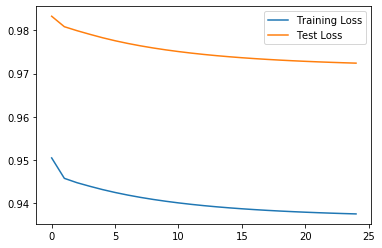

In [96]:
plt.plot(train_losses, label='Training Loss');
plt.plot(test_losses, label='Test Loss');
plt.legend()
plt.show()

These results are not great, MSE barely decreased over 25 epochs.

Remember, we used a very small subset of data, just 3.4M out of 20M ratings.

If we execute this using all available data, we will see much more desirable results.